In [1]:
import torch 
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from pd.nn.model import Conv

from pd.metric import amex_metric
from pd.data.loader import CustomerData, DataLoader
from pd.params import *
from pd.pred import pred_test_npy
from sklearn.model_selection import train_test_split


TabError: inconsistent use of tabs and spaces in indentation (params.py, line 21)

In [2]:
train_data = pd.read_parquet(DATADIR+"train_data.parquet")
train_labels = pd.read_csv(DATADIR+"train_labels.csv")
train_labels.set_index("customer_ID", inplace=True)


In [3]:
train_customers = train_data.customer_ID
train_count =  train_customers.value_counts()
train_c13 = train_count[train_count==13].index
train_data = train_data[train_data.customer_ID.isin(train_c13)]


In [3]:
data_cat_agg = train_data.groupby("customer_ID")[CATCOLS].agg(['count', 'last', 'nunique'])
    

In [5]:
data_cat_agg.shape

(458913, 33)

In [85]:
for c in CATCOLS:
    if c in betterTransFeatsK79:
        print(c)

D_114
D_116
D_120
D_63
D_64
D_66
D_68


In [86]:
CATCOLS

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_66',
 'D_68']

In [65]:
c = "R_13"
d = train_data["R_13"]


/var/folders/t2/_nykd9tn43dfx142nv5r8l900000gn/T/ipykernel_26043/888282133.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  slope = 2.944/(col_info13[c]["q95"] - mid_point)


In [66]:
slope

inf

In [64]:
a = ((d - col_info13["R_13"][f"mean_{lb}_{ub}"])/col_info13["R_13"][f"std_{lb}_{ub}"])

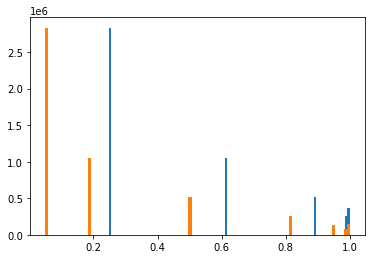

In [53]:
from scipy.stats import norm
_ = plt.hist(norm.cdf(a), bins=100)
_ = plt.hist(1/(1 + np.exp(slope*(mid_point - d))), bins=100)


In [4]:
    cols = featureCols

    if train_data is None:
        train_data = pd.read_parquet(TRAINDATA)
    if c13:
        train_customers = train_data.customer_ID
        train_count =  train_customers.value_counts()
        train_c13 = train_count[train_count==13].index
        train_data = train_data[train_data.customer_ID.isin(train_c13)]
        col_info_name = f"{col_info_name}13"

    for cat_col in CATCOLS:
        encoder = LabelEncoder()
        train_data[cat_col] = encoder.fit_transform(train_data[cat_col])
    
    col_info = {}
    for c in cols:
        col_info[c] = {}
        d = train_data[c]
        q2 = d.quantile(0.02)
        q98 = d.quantile(0.98)
        q5 = d.quantile(0.05)
        q95 = d.quantile(0.95)
        
        col_min_val = d.min()
        col_max_val = d.max()
        hist = np.histogram(d, range=[q2, q98], density=True, bins=100)
        
        col_info[c]["num_nan"] = 1 - d.dropna().shape[0]/d.shape[0]
        col_info[c]["q2"] = q2
        col_info[c]["q98"] = q98
        col_info[c]["q1"] = d.quantile(0.01)
        col_info[c]["q99"] = d.quantile(0.99)
        
        col_info[c]["min"] = col_min_val
        col_info[c]["max"] = col_max_val
        col_info[c]["mean"] = d.mean()
        col_info[c]["median"] = d.quantile(0.5)
        col_info[c]["hist"] = hist
        col_info[c]["max_prob_mass"] = hist[0].max()
        col_info[c]["num_nonzero_bins"] = np.count_nonzero(hist[0])
    

NameError: name 'c13' is not defined

In [20]:
nzs = []
dist_col_27 = []
for c in col_info.keys():
    nz = np.count_nonzero(col_info[c]["hist"][0])
    nzs.append(nz)
    if nz < 27:
        dist_col_27.append(c)

## Train with Conv Model

## Train with aggregation over the features

### Mean aggregation

In [34]:
from bes.nn.es_module import ESModule
import torch 
import torch.nn as nn
import torch.nn.functional as F

class MLP(ESModule):

    def __init__(self, input_dim, hidden_dim=128,):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.nf1 = nn.LayerNorm([hidden_dim])
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf2 = nn.LayerNorm([hidden_dim])
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf3 = nn.LayerNorm([hidden_dim])
        self.fc4 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf4 = nn.LayerNorm([hidden_dim])
        self.fc5 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf5 = nn.LayerNorm([hidden_dim])
        
        self.fcout = nn.Linear(in_features=hidden_dim, out_features=1)
    
    def forward(self, h, return_featues=False):
        h = F.selu(self.fc1(h))
        r = self.nf1(h)
        h = F.selu(self.fc2(r))
        h = self.nf2(h)
        h = F.selu(self.fc3(h))
        r = self.nf3(h+r)
        h = F.selu(self.fc4(r))
        h = self.nf4(h)
        h = F.selu(self.fc5(h))
        h = self.nf5(h+r)
        if return_featues:
            return torch.sigmoid(self.fcout(h)), h
        
        return torch.sigmoid(self.fcout(h))



In [42]:
# take the sum of the of the data and normalize by the max vals 
X = train_data.sum(axis=1) 
for idx, c in enumerate(dist_col_27):
    X[:, idx] = X[:, idx]/col_info[c]["max"]

X = X/X.max(axis=0)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=1/9, random_state=0, shuffle=True)
validation_data = (X_test, y_test)


In [60]:
train_dataset = CustomerData(X_train, train_labels=y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)


In [61]:
model_name = "mlp_col27_sum"
model = MLP(input_dim=91)
model = train_torch_model(model, train_loader, num_epochs=100, validation_data=validation_data, 
                            output_model_name=model_name)


0, BCE loss: 0.660, amex train: -0.043, val 0.000
0, BCE loss: 0.618, amex train: 0.281, val 0.000
0, BCE loss: 0.586, amex train: 0.452, val 0.000
0, BCE loss: 0.493, amex train: 0.490, val 0.000
0, BCE loss: 0.449, amex train: 0.490, val 0.000
0, BCE loss: 0.468, amex train: 0.505, val 0.000
0, BCE loss: 0.453, amex train: 0.525, val 0.000
0, BCE loss: 0.414, amex train: 0.529, val 0.000
0, BCE loss: 0.385, amex train: 0.536, val 0.000
0, BCE loss: 0.383, amex train: 0.567, val 0.000
0, BCE loss: 0.388, amex train: 0.553, val 0.000
0, BCE loss: 0.377, amex train: 0.570, val 0.000
0, BCE loss: 0.348, amex train: 0.588, val 0.000
0, BCE loss: 0.355, amex train: 0.580, val 0.000
0, BCE loss: 0.361, amex train: 0.585, val 0.000
0, BCE loss: 0.373, amex train: 0.590, val 0.000
0, BCE loss: 0.348, amex train: 0.607, val 0.000
0, BCE loss: 0.345, amex train: 0.608, val 0.000
0, BCE loss: 0.343, amex train: 0.612, val 0.000
0, BCE loss: 0.347, amex train: 0.605, val 0.000
0, BCE loss: 0.346,

## Train a model with only c27 (extract a feature for them)

## Aggregate Model with pre-trained conv

In [64]:
pred, conv_feat =  conv(torch.as_tensor(np.load(OUTDIR+"train_data_all.npy"), dtype=torch.float32), return_featues=True)

In [13]:
3.40+11.70+13.10+1.69+6.10

35.99

In [4]:
X = np.load(OUTDIR+"agg_feat.npy")

In [5]:
train_labels = np.load(OUTDIR+"train_labels_all.npy")
    

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=1/9, random_state=0, shuffle=True)
validation_data = (X_test, y_test)

train_dataset = CustomerData(X_train, train_labels=y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

    

In [6]:
from pd.nn.train_utils import train_torch_model
from bes.nn.es_module import ESModule
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [7]:

class MLP(ESModule):

    def __init__(self, input_dim, hidden_dim=128,):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.nf1 = nn.LayerNorm([hidden_dim])
        
        self.fcout = nn.Linear(in_features=hidden_dim, out_features=1)
    
    def forward(self, h, return_featues=False):
        h = F.selu(self.fc1(h))
        h = self.nf1(h)
        if return_featues:
            return torch.sigmoid(self.fcout(h)), h
        
        return torch.sigmoid(self.fcout(h))

In [8]:
class MLP(ESModule):

    def __init__(self, input_dim, hidden_dim=128,):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.nf1 = nn.LayerNorm([hidden_dim])
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf2 = nn.LayerNorm([hidden_dim])
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf3 = nn.LayerNorm([hidden_dim])
        self.fc4 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf4 = nn.LayerNorm([hidden_dim])
        self.fc5 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf5 = nn.LayerNorm([hidden_dim])
        
        self.fcout = nn.Linear(in_features=hidden_dim, out_features=1)
    
    def forward(self, h, return_featues=False):
        h = F.selu(self.fc1(h))
        r = self.nf1(h)
        h = F.selu(self.fc2(r))
        h = self.nf2(h)
        h = F.selu(self.fc3(h))
        r = self.nf3(h+r)
        h = F.selu(self.fc4(r))
        h = self.nf4(h)
        h = F.selu(self.fc5(h))
        h = self.nf5(h+r)
        if return_featues:
            return torch.sigmoid(self.fcout(h)), h
        
        return torch.sigmoid(self.fcout(h))


In [9]:
model = MLP(input_dim=X.shape[-1])
optimizer = torch.optim.Adam(model.parameters(),)
criterion = torch.nn.BCELoss()


for epoch in range(50): 
    for idx, (feat, clabel) in enumerate(train_loader):
        if len(feat.shape) == 4:  ## Reduce shape if its coming from a ratio version of the loader
            feat = feat.squeeze(dim=0)
            clabel = clabel.squeeze(dim=0)

        pred = model(feat)
        #weight = clabel.clone()
        #weight[weight==0] = 4
        #criterion.weight = weight
        loss = criterion(pred, clabel)
        
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model_metric = amex_metric(clabel.detach().numpy(), pred.detach().numpy())
        val_metrix = 0
        if model_metric > 0.78:
            X_test, y_test = validation_data
            val_features = torch.as_tensor(X_test, dtype=torch.float32)
            val_pred = model(val_features)
            val_metrix = amex_metric(y_test, val_pred.detach().numpy())

        log_message = f"{epoch}, BCE loss: {loss.item():.3f}, amex train: {model_metric:.3f}, val {val_metrix:.3f}"
        print(log_message)    

0, BCE loss: 0.887, amex train: -0.070, val 0.000
0, BCE loss: 0.457, amex train: 0.719, val 0.000
0, BCE loss: 0.343, amex train: 0.772, val 0.000
0, BCE loss: 0.239, amex train: 0.791, val 0.772
0, BCE loss: 0.262, amex train: 0.791, val 0.772
0, BCE loss: 0.294, amex train: 0.772, val 0.000
0, BCE loss: 0.259, amex train: 0.785, val 0.775
0, BCE loss: 0.233, amex train: 0.783, val 0.774
0, BCE loss: 0.225, amex train: 0.789, val 0.774
0, BCE loss: 0.251, amex train: 0.769, val 0.000
0, BCE loss: 0.267, amex train: 0.774, val 0.000
0, BCE loss: 0.252, amex train: 0.781, val 0.776
0, BCE loss: 0.227, amex train: 0.793, val 0.776
0, BCE loss: 0.228, amex train: 0.781, val 0.777
0, BCE loss: 0.221, amex train: 0.801, val 0.777
0, BCE loss: 0.236, amex train: 0.784, val 0.777
0, BCE loss: 0.237, amex train: 0.791, val 0.777
0, BCE loss: 0.235, amex train: 0.778, val 0.000
0, BCE loss: 0.225, amex train: 0.792, val 0.777
0, BCE loss: 0.223, amex train: 0.786, val 0.777
0, BCE loss: 0.224,

In [10]:
import lightgbm as lgb


In [ ]:
val_pred = model.predict(X_test)
amex_metric(y_test, val_pred)
        

# Train with Given preds

In [1]:
import os
import gc
import tempfile
import click
import json
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import Sampler, BatchSampler
from pd.metric import amex_metric
from pd.utils import write_log
from pd.nn.conv import ConvPred
from pd.utils import merge_with_pred, get_torch_agg_data, get_customers_data_indices, get_pred_data
from pd.params import *


In [7]:
train_data = np.load(OUTDIR+"train_logistic_raw_all_mean_q5_q95_q5_q95_data.npy")
train_labels = np.load(OUTDIR+"train_logistic_raw_all_mean_q5_q95_q5_q95_labels.npy")
    
pred_data = get_pred_data(type="train", id_dir='train_logistic_raw_all_mean_q5_q95_q5_q95_id.json')

model_name = f"conv_pred{agg}"
indices = get_customers_data_indices(num_data_points=np.arange(14), id_dir='train_logistic_raw_all_mean_q5_q95_q5_q95_id.json')


In [8]:
used_indices, other_indices = indices
oof_predictions = np.zeros(len(used_indices))
best_model_name, best_model_score = "", 0


In [11]:
model = ConvPred(input_dim=train_data.shape[-1], conv_channels=32, pred_dim=pred_data.shape[-1])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    model.to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
criterion = torch.nn.BCELoss()


In [12]:
labels = train_labels
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(used_indices, labels[used_indices])):
    pass 

In [13]:
x_cont_train, x_cont_val = train_data[used_indices][trn_ind], train_data[used_indices][val_ind]
y_train, y_val = labels[used_indices][trn_ind], labels[used_indices][val_ind]

x_pred_train, x_pred_val = pred_data[used_indices][trn_ind], pred_data[used_indices][val_ind]

batch_sampler_indices = np.arange(len(trn_ind))
np.random.shuffle(batch_sampler_indices)
sampler = BatchSampler(batch_sampler_indices, batch_size=BATCH_SIZE, drop_last=False, )


In [14]:
for idx, batch in enumerate(sampler):
    print(idx)
    cont_feat = torch.as_tensor(x_cont_train[batch], dtype=torch.float32).to(device)
    pred_feat =  torch.from_numpy(x_pred_train[batch]).to(device)
    clabel =  torch.as_tensor(y_train[batch], dtype=torch.float32).to(device)
    
    pred = model(cont_feat, pred_feat)


0


: 

: 

In [9]:
for idx, batch in enumerate(sampler):
    pass

In [10]:
cont_feat = torch.as_tensor(x_cont_train[batch], dtype=torch.float32).to(device)
cat_feat =  torch.as_tensor(x_cat_train[batch], dtype=torch.float32).to(device)
                
clabel =  torch.as_tensor(y_train[batch], dtype=torch.float32).to(device)
                

In [11]:
pred_feat =  torch.from_numpy(x_pred_train[batch]).to(device)
                

In [8]:
torch.from_numpy(x_pred_train[batch])

tensor([[0.1289, 0.0846, 0.1416,  ..., 0.1559, 0.2214, 0.2397],
        [0.0142, 0.0159, 0.0125,  ..., 0.0237, 0.0186, 0.0234],
        [0.0078, 0.0083, 0.0089,  ..., 0.0067, 0.0082, 0.0058],
        ...,
        [0.0074, 0.0072, 0.0087,  ..., 0.0039, 0.0074, 0.0038],
        [0.0135, 0.0051, 0.0110,  ..., 0.0047, 0.0064, 0.0035],
        [0.7553, 0.7993, 0.7244,  ..., 0.7417, 0.7407, 0.6851]],
       dtype=torch.float64)

In [12]:
model(cont_feat, cat_feat, pred_feat)


: 

: 